Step 1 - Import python libraries

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None

Step 2 - Load and read your data file
- pyTCR accepts a single `.tsv` file that should contain all the samples.
  - The following cell attempts to detect whether you are running the notebook in a Google Colab cloud environment or in a local environment, and then loads the data at the specified path.
- The `filePath` variable in the following code cell should be changed to the location of your file. The following options are supported:
  1. A `filePath` from Google Drive (to run on a cloud environment)
  2. A `filePath` from your local computer (to run on a local environment, other cloud environments should work as expected)
- The `data_adapter` notebook can be used to convert the data into the correct format for pyTCR to read.

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

df.head()

,sample,frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,age,gender,...,icu_admit,birth_year,blood_type,cmv_at_donation,days_from_last_symptom_to_sample,ethnicity,height_meters,hospitalized,weight_kg,race
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian


Step 3 - Create the standardized format (column content and column names)

- Sample name (sample)
- Clone frequency (freq)
- Clone reads count (#count)
- CDR3 amino acid clonotype (cdr3aa)
- CDR3 nucleotide (cdr3nt)
- V gene (v)
- D gene (d)
- J gene (j)
- Optional fields (here we use hospitalization as the clinical feature)

In [3]:
# Select the columns that are listed above
df = df[['sample','frequency', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df.columns = ['sample', 'freq' , '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

In [4]:
# Create a dataframe with reads count for each sample
df_reads = df.groupby(['sample', 'hospitalized']).agg(
    {'#count': 'sum'}).reset_index().rename(columns={'#count': "count"})

# Create a dataframe with clonotype count for each sample
df_diversity = df.groupby(['sample', 'hospitalized'], sort=False).size(
).reset_index(name='clonotype_count')

In [5]:
# Add clonotype count of each sample as a column to create a new dataframe
df = pd.merge(df, df_diversity, on=['sample', 'hospitalized'])

df

,sample,freq,#count,cdr3aa,cdr3nt,v,d,j,hospitalized,clonotype_count
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True,218977
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True,218977
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True,218977
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True,218977
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True,218977
...,...,...,...,...,...,...,...,...,...,...
15061643,1566265BW_TCRB,0.000001,1,CSVEDLRGGYTF,CTGACTGTGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCT...,TCRBV29-01,unknown,TCRBJ01-02*01,False,453526
15061644,1566265BW_TCRB,0.000001,1,CASGRRGDYGYTF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,unknown,TCRBJ01-02*01,False,453526
15061645,1566265BW_TCRB,0.000001,1,CASSWTGNSPLHF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,TCRBD02-01,TCRBJ01-06*02,False,453526
15061646,1566265BW_TCRB,0.000001,1,CASSLDWTEYYEQYF,CAGCCTGCAAAGCTTGAGGACTCGGCCGTGTATCTCTGTGCCAGCA...,TCRBV11-02*01,TCRBD01-01*01,TCRBJ02-07*01,False,453526


Diversity analysis 1 - Shannon-Wiener index [shannon_wiener_index]

In [6]:
# calculation step 1
df['shannon_index'] = -(df['freq']*np.log(df['freq']))

# calculation step 2
df_shannon = df.groupby(['sample', 'hospitalized']).agg(
    {'shannon_index': 'sum'}).reset_index().rename(columns={'': "shannon_index"})

# calculation step 3, Shannon-Wienex index is shown in the shannon_wiener_index column
df_shannon['shannon_wiener_index'] = np.exp(df_shannon['shannon_index'])
df_shannon_index = df_shannon[[
    'sample', 'hospitalized', 'shannon_wiener_index']]

Diversity analysis 2 - Normalized Shannon-Wiener index [normalized_shannon_wiener_index]

In [7]:
# calculation step 1 - merge df_shannon and df_diversity (which contains clonotype counts)
df_shannon = pd.merge(df_shannon, df_diversity, on=[
                      'sample', 'hospitalized'])

# calculation step 2 - calculate normalized Shannon-Wienex index, it is shown in the normalized_shannon_wiener_index column
df_shannon['normalized_shannon_wiener_index'] = df_shannon['shannon_index'] / \
    np.log(df_shannon['clonotype_count'])

df_norm_shannon = df_shannon[['sample', 'hospitalized',
                              'shannon_wiener_index', 'normalized_shannon_wiener_index']]

Diversity analysis 3 - Inverse Simpson index [inverse_simpson_index]

In [8]:
# calculation step 1
df['simpson_index'] = (df['freq']**2)

# calculation step 2
df_simpson = df.groupby(['sample', 'hospitalized']).agg(
    {'simpson_index': 'sum'}).reset_index().rename(columns={'': "simpson_index"})

# calculation step 3, Inverse Simpson index is shown in the inverse_simpson_index column
df_simpson['inverse_simpson_index'] = 1/df_simpson['simpson_index']

Diversity analysis 4 - Gini Simpson index [gini_simpson_index]


In [9]:
df_simpson['gini_simpson_index'] = 1-df_simpson['simpson_index']

Diversity analysis 5 - D50 index [D50_index]


In [10]:
# create an empty dataframe for storing results
df_D50 = pd.DataFrame()

# create a list of the sample names
samples = set(df['sample'])

for sample in samples:

    # store the rows related to the sample
    df_temp = df.loc[df['sample'] == sample]

    # sort the sample clonotypes by frequency in descending order
    df_temp = df_temp.sort_values(by='freq', ascending=False)

    # create a column to store the order
    df_temp['clonotype_number'] = np.arange(df_temp.shape[0])+1

    # compute and store the cumulative sum of the frequencies
    df_temp['accum_freq'] = df_temp['freq'].cumsum()

    # find out the first accumulated frequency that is above 50%
    df_temp = df_temp.loc[(df_temp['accum_freq'] >= 0.5)
                          & (df_temp['accum_freq'] <= 0.6)]
    df_temp = df_temp.head(1)

    # calculate D50 index and store in the result dataframe
    df_temp = df_temp.head(1)
    df_temp['D50_index'] = df_temp['clonotype_number'] / \
        df_temp['clonotype_count']*100
    df_D50 = pd.concat([df_D50, df_temp])

df_D50 = df_D50[['sample', 'hospitalized', 'D50_index']]

Diversity analysis 6 - Chao1 estimate [chao1] and standard deviation [chao1_SD]







In [11]:
# create an empty dataframe for storing results
df_chao1 = pd.DataFrame()

# get the columns needed for calculation from df
df1 = df[['sample', '#count', 'clonotype_count', 'hospitalized']]

# create a list of the sample names
samples = set(df1['sample'])

for sample in samples:

    # store the rows related to the sample
    df_temp = df1.loc[df1['sample'] == sample]

    # count singleton in the sample
    singleton = len(df_temp.loc[df_temp['#count'] == 1])

    # count doubleton in the sample
    doubleton = len(df_temp.loc[df_temp['#count'] == 2])

    # calculate Chao1 estimate
    chao1 = int(df_temp['clonotype_count'].values[0]) + \
        ((singleton * (singleton-1))/(2*(doubleton+1)))
    df_temp['chao1'] = chao1

    # calculate Chao1 estimate standard deviation
    step1 = 1/4*((singleton/doubleton)**4)
    step2 = (singleton/doubleton)**3
    step3 = 1/2*((singleton/doubleton)**2)
    step4 = doubleton * (step1+step2+step3)
    df_temp['chao1_SD'] = step4**(1/2)

    # store the results in the result dataframe
    df_chao1 = pd.concat([df_chao1, df_temp], axis=0, sort=False)

    # remove the duplicates results in the result dataframe
    df_chao1 = df_chao1[['sample', 'hospitalized', 'chao1', 'chao1_SD']]
    df_chao1 = df_chao1.drop_duplicates(subset=['sample'], keep='first')

Diversity analysis 7 - Gini coefficient [gini_coefficient]

In [12]:
# create an empty dataframe for storing results
df_gini = pd.DataFrame()

# create a list of the sample names
samples = set(df['sample'])

for sample in samples:

    # store the rows related to the sample
    df_temp = df.loc[df['sample'] == sample]

    def gini(list_of_values):
        sorted_list = sorted(list_of_values)
        height, area = 0, 0
        for value in sorted_list:
            height += value
            area += height - value / 2.
        fair_area = height * len(list_of_values) / 2.
        return (fair_area - area) / fair_area

    # calculate gini coefficient
    df_temp['gini_coefficient'] = gini(df_temp['freq'])

    # store the results in the result dataframe
    df_gini = pd.concat([df_gini, df_temp], sort=False)

    # remove the duplicates results in the result dataframe
    df_gini = df_gini[['sample', 'hospitalized', 'gini_coefficient']]
    df_gini = df_gini.drop_duplicates(subset=['sample'], keep='first')

Summary table for the diversity analysis

In [13]:
# create a dataframe that combines all the diversity analysis
dfs = [df_norm_shannon, df_simpson, df_D50, df_chao1, df_gini]

df_combined = pd.merge(dfs[0], dfs[1], left_on=['sample', 'hospitalized'], right_on=[
                       'sample', 'hospitalized'], how='outer')

for d in dfs[2:]:
    df_combined = pd.merge(df_combined, d, left_on=['sample', 'hospitalized'], right_on=[
                           'sample', 'hospitalized'], how='outer')

df_combined

,sample,hospitalized,shannon_wiener_index,normalized_shannon_wiener_index,simpson_index,inverse_simpson_index,gini_simpson_index,D50_index,chao1,chao1_SD,gini_coefficient
0,1132289BW_TCRB,False,25380.431993,0.789733,0.000049,20566.310911,0.999951,41.429316,2.084775e+06,11410.373284,0.319436
1,1222568BW_TCRB,False,13023.935151,0.746544,0.000143,7004.584037,0.999857,34.491398,1.502319e+06,8096.333443,0.412047
2,1337122BW_TCRB,False,21388.860051,0.764155,0.003713,269.338388,0.996287,36.383654,2.682283e+06,13306.917361,0.329197
3,1445BW_TCRB,False,14847.682803,0.734977,0.001507,663.542016,0.998493,25.637689,2.569078e+06,12316.618071,0.439525
4,1564208BW_TCRB,False,20020.296021,0.774762,0.000092,10895.432559,0.999908,36.576703,1.703006e+06,8928.384316,0.370510
5,1566265BW_TCRB,False,16680.493566,0.746421,0.000581,1720.624843,0.999419,33.769619,2.662749e+06,13646.111790,0.391194
6,1566319BW_TCRB,False,29025.511046,0.793120,0.000099,10091.303889,0.999901,43.370035,2.218496e+06,11090.841381,0.296313
7,1566426BW_TCRB,False,27081.645695,0.813889,0.000087,11551.584040,0.999913,46.192054,1.864089e+06,13030.216495,0.244315
8,1566449BW_TCRB,False,17759.436598,0.763780,0.000156,6416.291221,0.999844,45.114811,1.932286e+06,10429.199800,0.310889
9,1566486BW_TCRB,False,23000.794049,0.762707,0.000746,1340.431932,0.999254,50.560175,4.006665e+06,21730.358941,0.237706


## Figure5a - Shannon-Wiener index

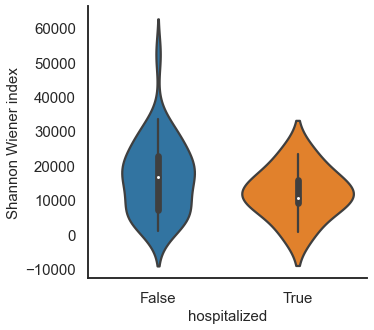

In [14]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.violinplot(x=attribute, y='shannon_wiener_index', data=df_combined)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Shannon Wiener index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS5a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5a.png",bbox_inches="tight")

plt.show()

## Figure5b - Normalized Shannon-Wiener index 

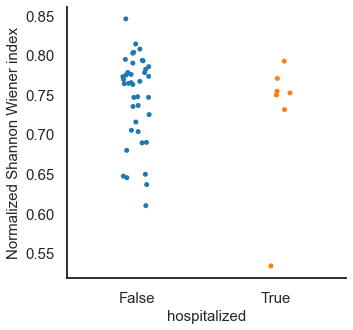

In [15]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.stripplot(x=attribute, y='normalized_shannon_wiener_index', data=df_combined)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Normalized Shannon Wiener index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS5b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5b.png",bbox_inches="tight")

plt.show()

## Figure5c - Inverse Simpson index

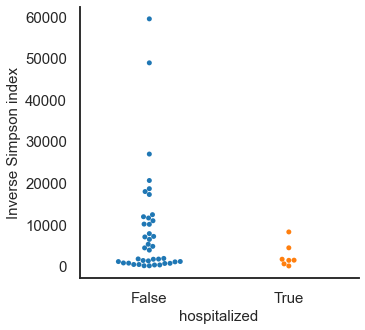

In [16]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.swarmplot(x=attribute, y='inverse_simpson_index', data=df_combined)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Inverse Simpson index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS5c.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5c.png",bbox_inches="tight")

plt.show()

## Figure5d - Gini Simpson index 

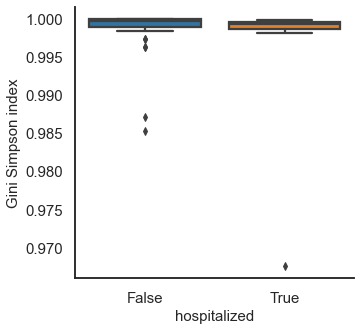

In [17]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.boxplot(x=attribute, y='gini_simpson_index', data=df_combined)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Gini Simpson index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS5d.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5d.png",bbox_inches="tight")

plt.show()

## Figure5e - D50 index

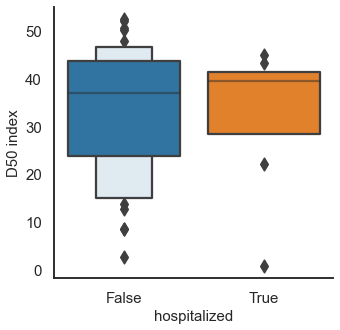

In [18]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.boxenplot(x=attribute, y='D50_index', data=df_combined)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('D50 index', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS5e.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5e.png",bbox_inches="tight")

plt.show()

## Figure5f - Chao1 estimate

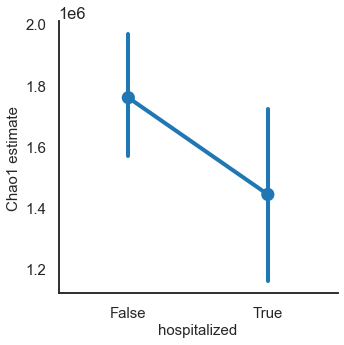

In [19]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.pointplot(x=attribute, y='chao1', data=df_combined)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Chao1 estimate', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS5f.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5f.png",bbox_inches="tight")

plt.show()

## Figure5g - Gini coefficient

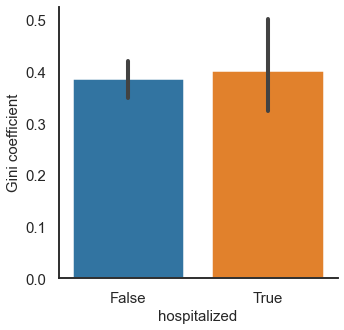

In [20]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(5,5))

ax = sns.barplot(x=attribute, y='gini_coefficient', data=df_combined)

ax.set_xlabel(attribute, fontsize=15)
ax.set_ylabel('Gini coefficient', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

plt.savefig("../figures/supplementary/figureS5g.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS5g.png",bbox_inches="tight")

plt.show()